In [1]:
import torch
import torch.nn as nn
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import math
import self_model as models
import get_data

In [5]:
data_path = "C://Users//shjdl//Desktop//DM_project//data//"
train_path = data_path+"train.csv"
valid_path = data_path+"validation.csv"

train_raw_data = pd.read_csv(train_path, iterator=True)
train_data = train_raw_data.get_chunk(40000).values.astype('uint8')
valid_raw_data = pd.read_csv(valid_path, iterator=True)
valid_data = valid_raw_data.get_chunk(10000).values.astype('uint8')


In [6]:
BATCH_SIZE = 16
NUM_EPOCHS = 300
LR = 0.01

model = models.SEResNeXt(models.BottleneckX, [3, 4, 6, 3],cardinality=32, num_classes=10)
# model = models.AllConvNet()
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adadelta(model.parameters(), 0.9)

optimizer = optim.SGD(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 60, gamma = 0.1)

# optimizer = optim.Adam(model.parameters(), lr=LR, betas=(0.9, 0.99))

train_dataset = get_data.TrainDataset(train_data)
valid_dataset = get_data.ValidDataset(valid_data,500)
train_loader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [ ]:
seque = []
tloss = []
epochloss=[]
valid = []
processed = 0
times = 0

for epoch in range(NUM_EPOCHS):    
    
    scheduler.step()
    
    for images, labels in tqdm(train_loader,disable = True):
        images = images.type(torch.FloatTensor).cuda()
        labels = labels.type(torch.LongTensor).cuda()
        model = model.cuda()
        
        out = model(images)
        loss = criterion(out, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        times = times+1
        processed += BATCH_SIZE
        if processed%10000==0:
            print("epoch %d, %d data processed, current entropy is %f" % (epoch, processed, loss.data.item()))
            seque.append(times)
            tloss.append(loss.data.item())
    train_acc = 0
    valid_loader = data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
    for images, labels in tqdm(valid_loader,disable =True):
        images = images.type(torch.FloatTensor)
        labels = labels.type(torch.LongTensor)
        images = images.cuda()
        labels = labels.cuda()
        model = model.cuda()
        out = model(images)
        _, pred = torch.max(out, 1)
        num_correct = (pred == labels).sum()
        train_acc += num_correct.item()
    epochloss.append(loss.data.item())
    valid.append(train_acc / 500)
    print("epoch %d, %d data processed, current validation is %f" % (epoch, processed, train_acc / 500))

epoch 0, 10000 data processed, current entropy is 1.791082
epoch 0, 20000 data processed, current entropy is 2.012074
epoch 0, 30000 data processed, current entropy is 1.807365
epoch 0, 40000 data processed, current entropy is 1.691597
epoch 0, 40000 data processed, current validation is 0.426000
epoch 1, 50000 data processed, current entropy is 1.454247
epoch 1, 60000 data processed, current entropy is 1.322613
epoch 1, 70000 data processed, current entropy is 1.214434
epoch 1, 80000 data processed, current entropy is 1.362554
epoch 1, 80000 data processed, current validation is 0.508000
epoch 2, 90000 data processed, current entropy is 1.140758
epoch 2, 100000 data processed, current entropy is 0.879305
epoch 2, 110000 data processed, current entropy is 1.197255
epoch 2, 120000 data processed, current entropy is 0.883987
epoch 2, 120000 data processed, current validation is 0.544000
epoch 3, 130000 data processed, current entropy is 0.654091
epoch 3, 140000 data processed, current en

D:\tf\envs\tfgpu\lib\site-packages\torch\serialization.py:241: UserWarning: Couldn't retrieve source code for container of type SEResNeXt. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
D:\tf\envs\tfgpu\lib\site-packages\torch\serialization.py:241: UserWarning: Couldn't retrieve source code for container of type BottleneckX. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
D:\tf\envs\tfgpu\lib\site-packages\torch\serialization.py:241: UserWarning: Couldn't retrieve source code for container of type Selayer. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


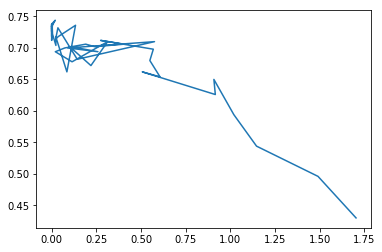

In [9]:
datetime =time.strftime('%Y.%m.%d',time.localtime(time.time()))
PATH = "./model-" +datetime+ ".pt"
torch.save(model, PATH) 

model=torch.load(PATH)
plt.plot(epochloss,valid)
plt.show()

D:\tf\envs\tfgpu\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
